In [1]:
import os
image_path = "../dataset/pizza_steak_sushi/"

train_dir = os.path.join(image_path, "train")
test_dir = os.path.join(image_path, "test")

In [2]:
from torchvision import transforms
from data_setup import createDataloader

train_transform = transforms.Compose(
    [   
        transforms.Resize((224, 224)) ,
        transforms.ToTensor()

    ]
)

train_DL, test_DL, _classes = createDataloader(train_dir, test_dir, 32, train_transform, train_transform )

In [3]:
len(train_DL)

71

In [4]:
_classes

['pizza', 'steak', 'sushi']

31


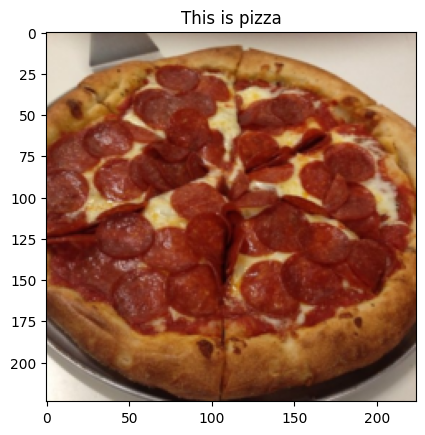

In [65]:
# data visuals
import  matplotlib.pyplot as plt
from PIL import Image
import random

img, lable = next(iter(test_DL))

rand_id = random.randint(0,31)
print(rand_id)

show_img = img[rand_id]
plt.title("This is {}".format(_classes[lable[rand_id]]))
plt.imshow(show_img.permute(1,2,0))

# Replicating ViT

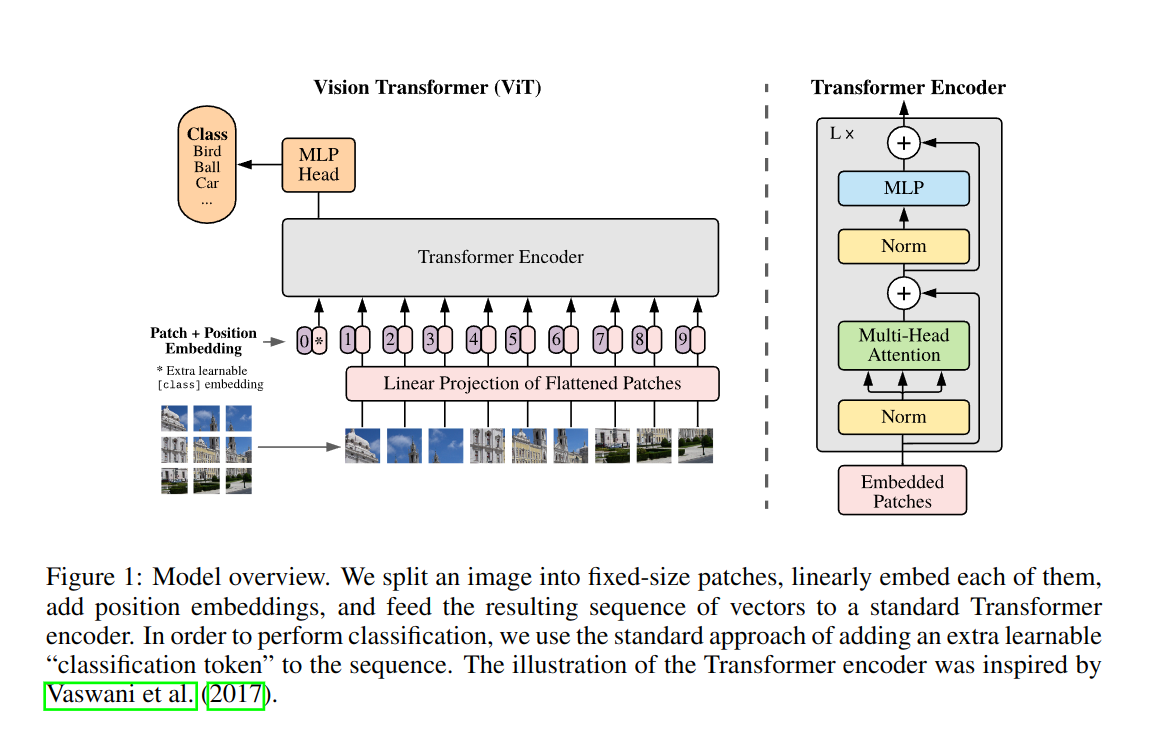

### Embedding - Leaning representations, start from a random initialization and improve them through training.
    - 1D vector will be input to the model


##### * Equation 1
```python
x_input = [class_token, image_patch1, image_patch2,.. image_patchN] + [class_token_pos, image_patch1_pos, image_patch2_pos,.. image_patchN_pos]
```

##### * Equation 2
```python
x_MSA_output = MultiHSA(LayerNorm(x_input)) + x_input
```

##### * Equation 3
```python
x_MLP_output = MLP(LayerNorm(x_MSA_output)) + x_MSA_output
```

<b>MLP - Multi Layer Perceptron (a nn with multiple layers)</b>

##### Equation 4 - Output
```python
x_output = LinearLayer(LayerNorm(x_MLP_output))
```

## Patch position and class Embeding

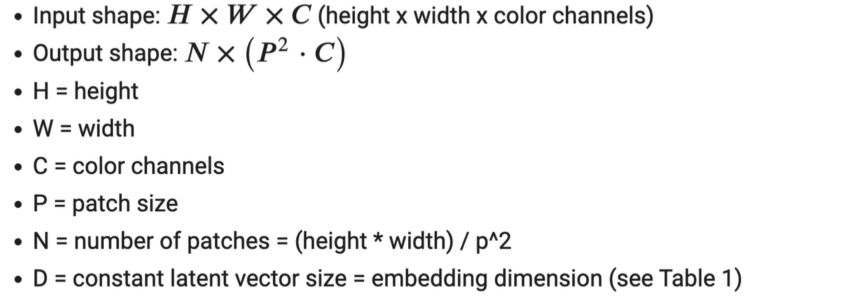

In [29]:
H = 224
W = 224
C = 3
P = 16
N = int((H * W) / P**2)
N

196

In [30]:
embbeding_inp_shape = (H,W,C)
embbeding_out_shape = (N , (P**2) * C)


print("Input Shape:",embbeding_inp_shape)
print("Output Shape:",embbeding_out_shape, "(Number of patches, embedding size)")


Input Shape: (224, 224, 3)
Output Shape: (196, 768) (Number of patches, embedding size)


In [31]:
# turing image to patch

In [32]:
# Ploting first dim of the image
img[0][:,:1,:].shape

torch.Size([3, 1, 224])

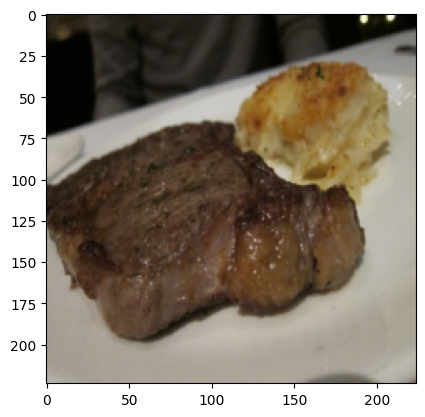

In [33]:
plt.imshow(img[rand_id].permute(1,2,0))

In [34]:
img_size = 224
patch_size = 16

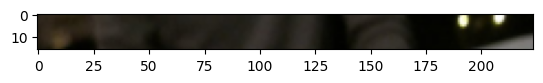

In [35]:
plt.imshow(img[rand_id][:,:patch_size,:].permute(1,2,0))

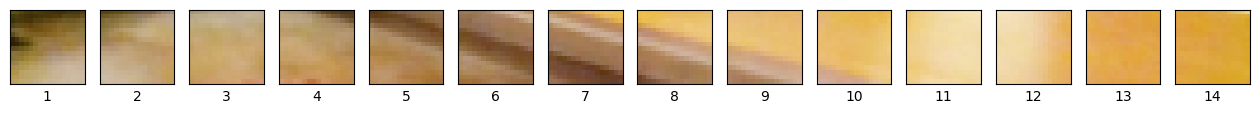

In [36]:

num_patches = img_size // patch_size
assert img_size % patch_size == 0, "image size is not exactly divisible"
# plt.imshow(img[0][:,:patch_size,:patch_size].permute(1,2,0))

fig, axs = plt.subplots(nrows=1, ncols=img_size//patch_size, sharex=True, sharey=True, figsize=(patch_size, patch_size))

# iter ver a pactch
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(img[0][:,:patch_size,patch:patch+patch_size].permute(1,2,0))
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

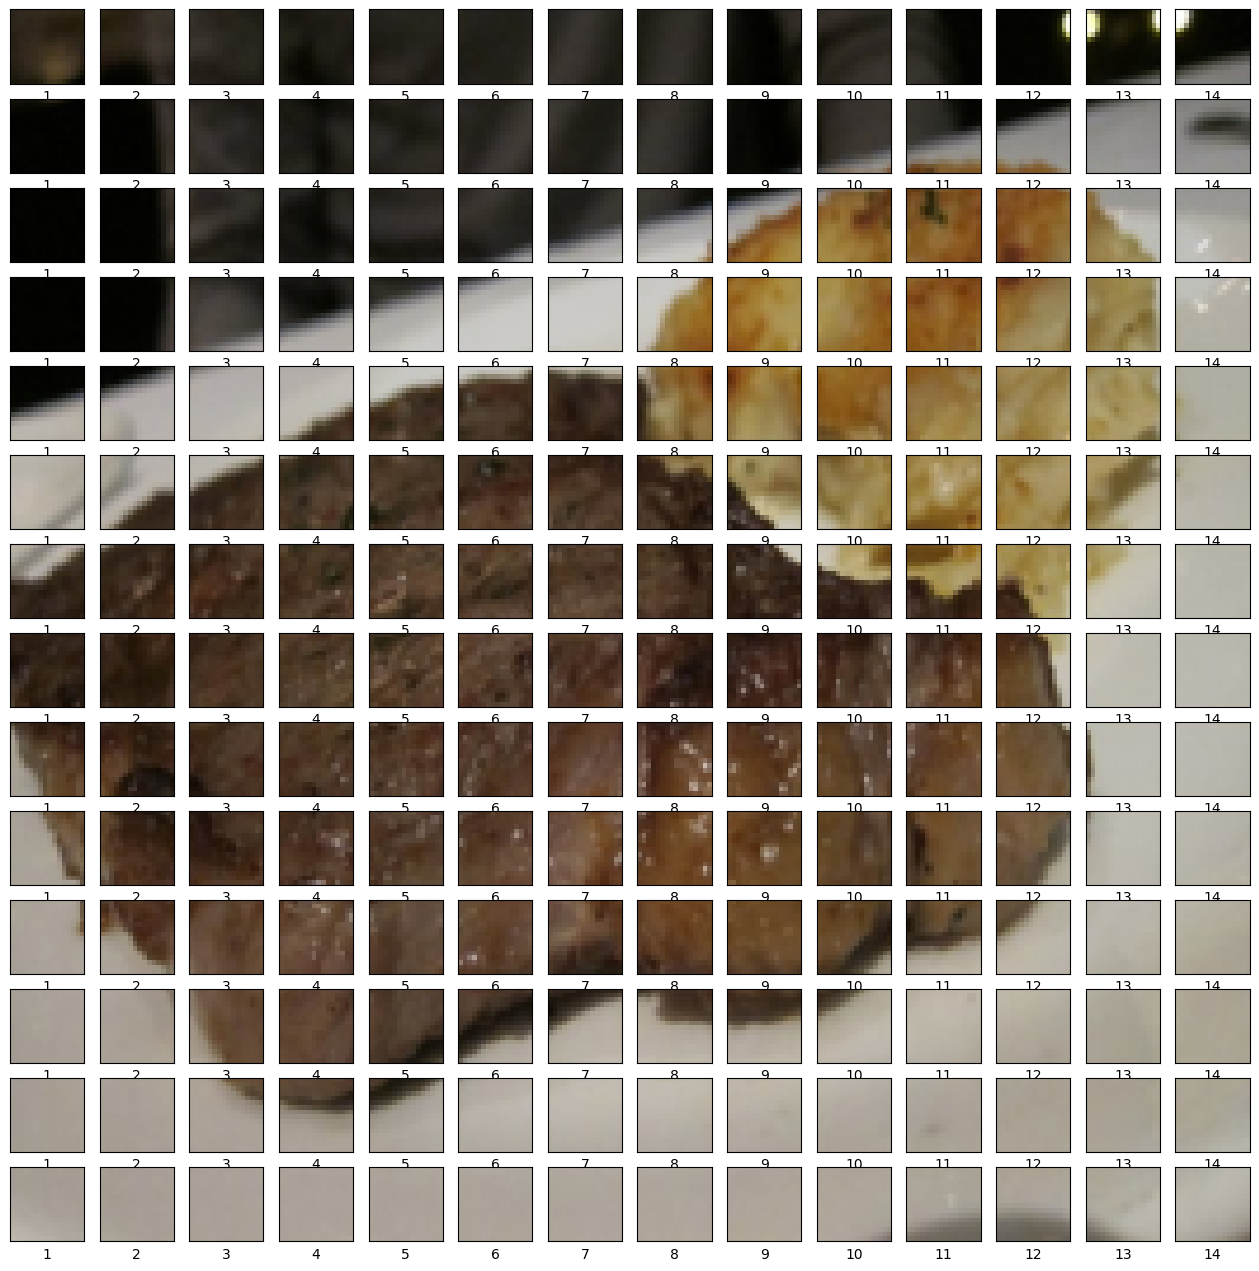

In [37]:
## ploting whole image as a patch

img_size = 224
patch_size = 16

num_patches = img_size // patch_size
assert img_size % patch_size == 0, "image size is not exactly divisible"
# plt.imshow(img[0][:,:patch_size,:patch_size].permute(1,2,0))

fig, axs = plt.subplots(nrows=img_size//patch_size, ncols=img_size//patch_size, sharex=True, sharey=True, figsize=(patch_size, patch_size))

for j, patch_j in enumerate(range(0, img_size, patch_size)):
    for i, patch_i in enumerate(range(0, img_size, patch_size)):
        axs[j,i].imshow(img[rand_id][:,patch_j:patch_j+patch_size,patch_i:patch_i+patch_size].permute(1,2,0))
        axs[j,i].set_xlabel(i+1)
        axs[j,i].set_xticks([])
        axs[j,i].set_yticks([])

In [38]:
# applying conv2d to cut into patches

from torch import nn

conv2D = nn.Conv2d(in_channels=3,out_channels=768, # 768 from paper ((P**2) * C)
                   stride=patch_size, kernel_size=patch_size, padding=0)

In [39]:
conv2D

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [40]:
img[0].squeeze(0).shape

torch.Size([3, 224, 224])

torch.Size([32, 768, 14, 14])

In [80]:
patched_img = conv2D(img.squeeze(0))
patched_img.shape

torch.Size([32, 768, 14, 14])

In [82]:
conv2D(img.squeeze(0)).shape

torch.Size([32, 768, 14, 14])

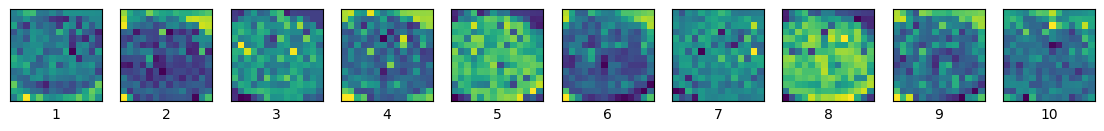

In [74]:
# visulizing feature map

fig, axs = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(14,14))

conv2d_out = conv2D(img[rand_id])

for i in range(0,10):
    tmp_rand = random.randint(0, 768)

    axs[i].imshow(conv2d_out[tmp_rand].detach().numpy())
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [87]:
flat = nn.Flatten(start_dim=2, end_dim=3)
flat_img_conv = flat(patched_img)
# plt.imshow(flat(patched_img)[0])

In [89]:
#rearranging flattern dim
flat_img_conv.permute(0,2,1).shape

torch.Size([32, 196, 768])

In [100]:
flat_img_conv[:,:,0].shape

torch.Size([32, 768])

In [114]:
# img to patch embedding layer (img to pacth embedding)

# pacth_size = 16

# img_to_seq = nn.Sequential(
#     nn.Conv2d(3, 768, patch_size, patch_size, padding=0),
#     nn.Flatten(start_dim=2, end_dim=3)
# )

# img_size(img)

class PatchEmbedding(nn.Module):
    def __init__(self, color_channel, num_patch, patch_size):
        super().__init__()
        self.conv_layer = nn.Conv2d(in_channels=color_channel, 
                               out_channels=num_patch,
                               kernel_size=patch_size,
                               stride=patch_size, 
                               padding=0)
        self.flat = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        x = self.conv_layer(x)
        return self.flat(x).permute(0,2,1) # batch, number_of_patch, embedding_dim

pe = PatchEmbedding(3, 768, 16)
print(img.shape)
pe(img).shape



torch.Size([32, 3, 224, 224])


torch.Size([32, 196, 768])